In [101]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'

ROOT_DIR = BRANDON
# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

In [102]:
from utilities import *
from plot_utilities import *
''' Comment out the below two lines if you do not have Matlab installed and opened'''
import matlab.engine 
eng = matlab.engine.connect_matlab()

In [106]:
prior_cdf = compute_prior_cdf(0.7, -1.3, n_samples= 1000, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng)

Params: 0.7, -1.3
Chebyshev bound: 53.7979596021394
No tail


100%|██████████| 500/500 [00:01<00:00, 309.81it/s]

First CDF value: 1.3675910528521007e-19
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.0970047122813592, pvalue=2.3411783641783283e-82, statistic_location=0.019505011866983404, statistic_sign=1)


In [96]:
sampled = sample_prior(0.7, -1.3, size = 10000)

In [97]:
kstest_custom(sampled, prior_cdf)

(0.015985331671690084, 0.01193471758452639)

In [123]:
def compute_cdf_vals(r, beta, xs, use_matlab = True, debug = False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs))):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gauss_density(z, x):
            return np.exp(-0.5 * (x/z)**2) / (np.sqrt(2*np.pi) * z)

        def gen_gamma_cdf(x):
            return prior_cdf.gammainc(beta, x**r)

        def integrand(z, x):
            return gauss_density(z, x) * (1 - gen_gamma_cdf((x/z)**2))
        
        for j, x in enumerate(xs):
            res = integrate.quad(integrand, 0, np.inf, args=(x,))[0]
            prior_cdf[j] = res
    return prior_cdf
    

In [178]:
def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=eng, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: {r}, {eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = np.zeros_like(xs_minus)


    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab = use_matlab, debug = debug)


    print(prior_cdf_minus)
    if(max(abs(np.diff(prior_cdf_minus)))):
        inv_linspline = interpolate.InterpolatedUnivariateSpline(x= prior_cdf_minus, y= xs_minus, k=1, ext='const')
        normal = interpolate.InterpolatedUnivariateSpline(x= xs_minus, y= prior_cdf_minus, k=1, ext='const')
        #return normal, inv_linspline
        
    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1-np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.ks_1samp(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.08:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

In [179]:
xs, cdf = compute_prior_cdf_using_gamma_cdf(0.5, -0.5, n_samples= 1000, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)


Params: 0.5, -0.5
Chebyshev bound: 244.94897427831782
Tail samples: 100


100%|██████████| 500/500 [00:01<00:00, 371.57it/s]

[4.94635600e-25 7.00243611e-25 9.49441417e-25 1.96697354e-24
 2.43314615e-24 3.09774679e-24 4.70026482e-24 5.94840166e-24
 9.64129232e-24 1.32282402e-23 1.84598541e-23 2.63147005e-23
 3.57753275e-23 5.37530680e-23 7.27784015e-23 9.70117145e-23
 1.33963704e-22 2.07470370e-22 2.73106681e-22 3.57719560e-22
 4.98296056e-22 6.57557052e-22 8.92873782e-22 1.19582265e-21
 1.74576627e-21 2.31217118e-21 3.04368826e-21 4.15984697e-21
 5.58017311e-21 7.43916075e-21 9.86760316e-21 1.32590548e-20
 1.82575188e-20 2.39629576e-20 3.15597896e-20 4.21334409e-20
 5.58341384e-20 7.35391797e-20 9.70649392e-20 1.27468144e-19
 1.67283463e-19 2.22223638e-19 2.89888189e-19 3.77634749e-19
 4.95175831e-19 6.45638696e-19 8.39380185e-19 1.08863201e-18
 1.41406241e-18 1.83079041e-18 2.36510022e-18 3.06490549e-18
 3.94580678e-18 5.07218368e-18 6.52291777e-18 8.36835885e-18
 1.07168388e-17 1.37111537e-17 1.75047088e-17 2.23174819e-17
 2.84223449e-17 3.61677787e-17 4.58927278e-17 5.81657787e-17
 7.36478165e-17 9.308173

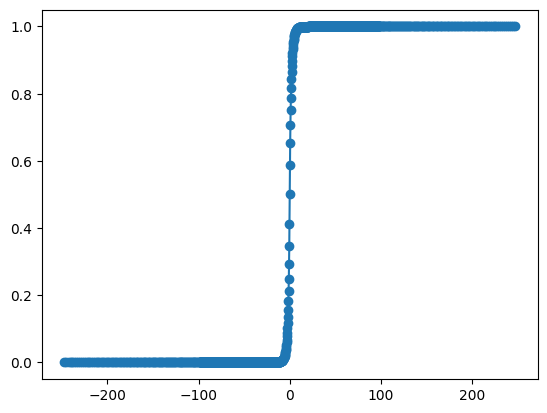

In [180]:
plt.plot(xs, cdf(xs))
plt.scatter(xs, cdf(xs))